# Predicting Bike Rentals

The purpose of this project is to predict the total number of bikes people rent in a given hour. The dataset we'll be using is from Washington, D.C.'s data on their bike sharing program. The data was compiled into a CSV file by [Hadi Fanaee-T](http://folk.uio.no/hadift/).

Here are the descriptions for the relevant columns for this project:


- instant: A unique sequential ID number for each row
- dteday: The date of the rentals
- season: The season in which the rentals occurred
- yr: The year the rentals occurred
- mnth: The month the rentals occurred
- hr: The hour the rentals occurred
- holiday: Whether or not the day was a holiday
- weekday: The day of the week (as a number, 0 to 7)
- workingday: Whether or not the day was a working day
- weathersit: The weather (as a categorical variable)
- temp: The temperature, on a 0-1 scale
- atemp: The adjusted temperature
- hum: The humidity, on a 0-1 scale
- windspeed: The wind speed, on a 0-1 scale
- casual: The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered: The number of registered riders (people who had already signed up)
- cnt: The total number of bike rentals (casual + registered)

# Importing the Data

In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')

print(bike_rentals.shape)
bike_rentals.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


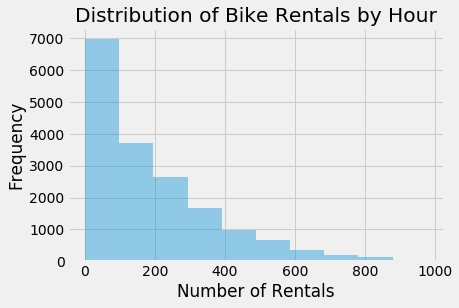

In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

style.use('fivethirtyeight')

sns.distplot(bike_rentals['cnt'], bins=10, kde=False, norm_hist=False, axlabel='Number of Rentals')
plt.ylabel('Frequency')
plt.title('Distribution of Bike Rentals by Hour')

plt.show()

Most hours in the dataset report the number of rentals as being between 0 and 100. The data is strongly skewed to the right, which means we have outliers at the extreme end of the spectrum.

In [3]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Columns worth exploring:

- instant: Meaningless, since this column is essentially the index
- season: Isn't very high, but it is significant
- yr: Relatively high. Worth investigating
- mnth: Not very high, but potentially significant. Suspect this column is redundant as it likely correlates strongly with season
- hr: Strong correlation. Bundling hours into morning, afternoon, evening, and night might yield better predictions
- weathersit: Makes sense this would be correlated (doubt many would enjoy riding in the rain)
- temp: Highly correlated, as expected. Worth exploring relationship to weathersit.
- atemp: Highly correlated, though potentially redundant.
- hum: Highly correlated. Makes sense; high humidity likely means hot and muggy conditions or rainy conditions, neither of which are optimal for riding a bike.
- windspeed: Slight correlation. Though not very high, it's interesting.
- casual: Meaningless because it leaks the target variable
- registered: Meaningless because it leaks the target variable


# Feature Engineering

In [4]:
def assign_label(hour):
    '''
    Returns a value corresponding to time of day based on the hour passed in.
    
    1: Morning (6-12)
    2: Afternoon (12-18)
    3: Evening (18-24)
    4: Night (0-6)
    '''
    
    if 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    elif 18 <= hour < 24:
        return 3
    elif 0 <= hour < 6:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


# Choosing Error Metric

Plotting the distribution of 'cnt' reveals a right-skewed distribution, which means we have outliers in the data. We need to think about the importance of those outliers before building our model. 

Let's think about the data for a moment, and what precisely we want to predict and why we want to predict it. The data represents two years of bike rental data, with each entry recording data for a single hour. The target variable is the number of bikes sold within that hour. Considering what we know about the data, how important are the hours during which an incredibly high number of rentals were recorded? 

This is a really difficult question to answer. I think it boils down to the model's intended use. Do we want to be able to predict high-volume hours with accuracy, or do we want a model with generally good accuracy overall even if it fails to predict high-volume hours? I'm just brainstorming here, but if we're chiefly concerned with being able to reliably meeting demand, then the outliers aren't as important as overall accuracy is. If, on the other hand, we want to maximize revenue from bike rentals, then outliers seem important, because we ultimately want to aim for pushing our mean number of sales closer to those outliers.

Even considering these two use cases, there are a few ways we could handle the outliers. The simplest way would be to ignore their impact and use MAE as our error metric to get a general idea of how well the model performs. Another way to handle the outliers would be to use RMSE as our error metric and run the model with and without the outliers to see just how strongly they affect the predictions.

Something else to consider is how well these two metrics accurately describe the model's performance. Though MAE and RMSE give an idea of how well the model is performing using the training data, I don't think they give a very strong indication of whether the model is over or underfitting. 

For now, I'm going to settle for MAE because I don't think the outliers are very important.

# Splitting data into train and test sets

In [5]:
# Randomly select 80% of the rows from our dataset for the train set
train = bike_rentals.sample(frac=.8)

# Select all remaining rows from our dataset for our test set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

# Feature Selection

In [6]:
# Let's start out by droppping columns that leak data or don't contribute any meaningful information
features = bike_rentals.drop(['instant', 'cnt', 'registered', 'casual', 'dteday'], axis=1).columns
features

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

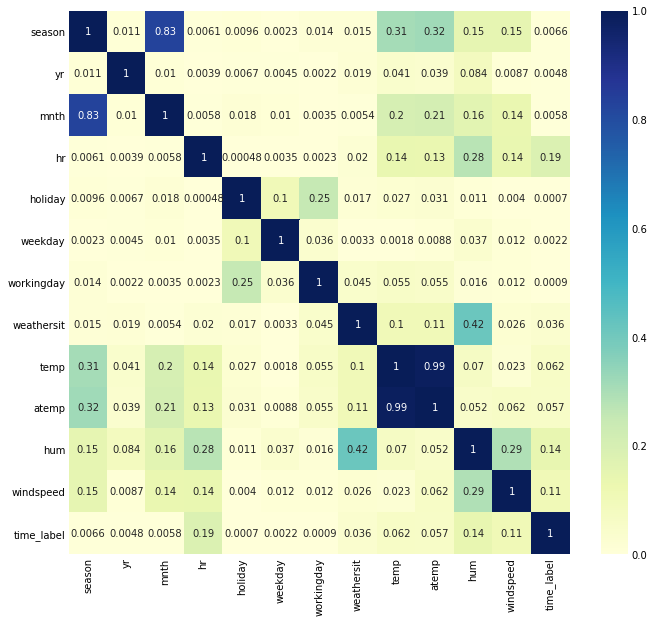

In [7]:
# Now let's check for correlation between features to drop redundant columns
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(bike_rentals[features].corr().abs(), annot=True, cmap='YlGnBu')
plt.show()

This looks pretty straightforward! Look at that almost perfect correlation between temp and atemp. We'll need to decide which to keep, though I doubt it matters much. Let's keep the temp column. As I expected after running the initial correlations with our target variable, the month column is highly correlated with season. Which one should we keep? I'm not sure, but here's what I think: 

- Keeping the month column provides more granularity which may increase noise. 
- If we keep the season column, on the other hand, we'll lose that granularity and potentially significant information, but we'll potentiall gain accuracy. 

I'm worried the granularity in the month column may negatively impact our predictions, so I'm going to keep the season column instead. It may be worth running the model with one and then the other just to be sure.

Some other variable relationships are bothering me. Look at the relationship between 'hum' and 'weathersit' for example. That's a relatively high correlation, and it makes sense since rain obviously means higher humidity, for example. I'm tempted to drop one of the columns, but I fear doing so would drop meaningful information. The 'hum' column is more strongly correlated with our target variable, but does that necessarily mean it's more significant? The 'weathersit' column also has a significantly high correlation with our target variable, though it is admittedly a weaker correlation. Here's another thought; the information lost by dropping 'weathersit' may be preserved by way of the combination of two other variables, namely 'hum' and 'temp'. With that line of thinking, let's drop 'weathersit'.

The relationship between 'season' and 'temp' is potentially problematic. What do we do with these columns? There's obviously a relationship between season and temperature, but there are other things implied by the season that are lost in the temperature column. Some seasons are more popular for D.C. tourism, despite temperature (and admittedly sometimes, though not always, because of temperature). With these considerations, I think it's important to keep both columns.

One final thing to consider is whether we need all three of the 'holiday', 'weekday', and 'workingday' columns. Because 'holiday' and 'workingday' have almost the same correlation with our target variable (though of opposite magnitudes), I think it's safe to drop one. Let's drop 'holiday'.

That's a lot to digest, so to recap, we're dropping:

- atemp
- mnth
- weathersit
- holiday

In [8]:
# Let's drop those features
features = features.drop(['atemp', 'mnth', 'weathersit', 'holiday'])

features

Index(['season', 'yr', 'hr', 'weekday', 'workingday', 'temp', 'hum',
       'windspeed', 'time_label'],
      dtype='object')

In [9]:
# Let's also drop the 'hr' column since we've converted it in another step
features = features.drop('hr')
features

Index(['season', 'yr', 'weekday', 'workingday', 'temp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

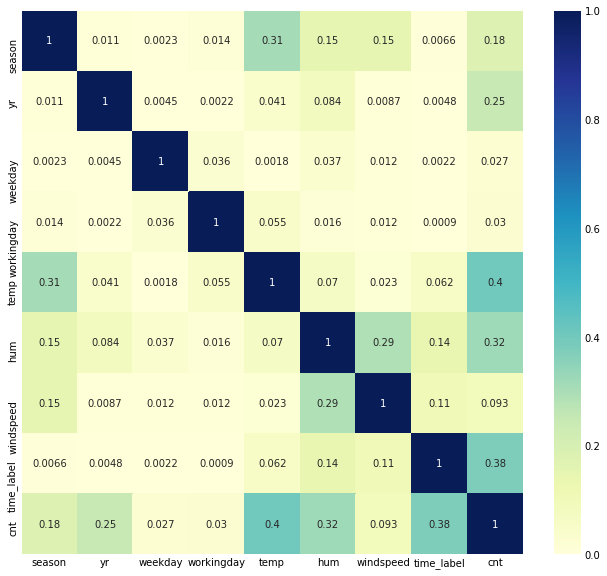

In [10]:
# One last correlation check just to be sure we haven't missed anything and to check correlation with target
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(pd.concat([bike_rentals[features], bike_rentals['cnt']], axis=1).corr().abs(), annot=True, cmap='YlGnBu')
plt.show()

Let's go ahead and just drop 'weekday' and 'workingday'. The correlation is so low that I doubt they'll add anything meaningful to our algorithm.

In [11]:
features = features.drop(['weekday', 'workingday'])
features

Index(['season', 'yr', 'temp', 'hum', 'windspeed', 'time_label'], dtype='object')

We've dropped a lot of predictors which means we may have inadvertently introduced more model bias. We may have to experiment with adding more features iteratively to see how our model is affected.

# Building the linear regression model

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(train[features], train['cnt'])

predictions = model.predict(test[features])

mae = mean_absolute_error(test['cnt'], predictions)
mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)

print('MAE: {0}\nMSE: {1}\nRMSE: {2}'.format(mae, mse, rmse))

MAE: 102.7108496999495
MSE: 18847.613142305956
RMSE: 137.2866094792422


I've included MSE and RMSE to demonstrate just how profoundly the outliers affect our model. In any case, the error is still very high. Let's try to reduce the error with decision trees.

# Modeling with decision tree regressor

In [13]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

model.fit(train[features], train['cnt'])

predictions = model.predict(test[features])

mae = mean_absolute_error(test['cnt'], predictions)
mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)

print('MAE: {0}\nMSE: {1}\nRMSE: {2}'.format(mae, mse, rmse))

MAE: 105.48158734725192
MSE: 26559.246192552295
RMSE: 162.97007759877977


The result is higher because it's making too many branches in the decision tree. Let's tweak the regressor to fix that.

In [14]:
min_samples = np.arange(2,22,2)

for m in min_samples:
    model = model = DecisionTreeRegressor(min_samples_leaf=m)

    model.fit(train[features], train['cnt'])

    predictions = model.predict(test[features])

    mae = mean_absolute_error(test['cnt'], predictions)
    mse = mean_squared_error(test['cnt'], predictions)
    rmse = np.sqrt(mse)

    print('min_leaf_samples: {0}\nMAE: {1}\nMSE: {2}\nRMSE: {3}\n'.format(m, mae, mse, rmse))

min_leaf_samples: 2
MAE: 97.69993629787933
MSE: 22503.62861675558
RMSE: 150.01209490156313

min_leaf_samples: 4
MAE: 88.43269561677933
MSE: 17856.76196489956
RMSE: 133.62919578033672

min_leaf_samples: 6
MAE: 86.28229851356289
MSE: 17002.139643524122
RMSE: 130.39225300424914

min_leaf_samples: 8
MAE: 85.06405710751244
MSE: 16293.439755081568
RMSE: 127.6457588605339

min_leaf_samples: 10
MAE: 84.25717722864813
MSE: 15783.71801841863
RMSE: 125.63326796043566

min_leaf_samples: 12
MAE: 84.08639178179577
MSE: 15360.074824576172
RMSE: 123.93576894737117

min_leaf_samples: 14
MAE: 83.60540877074745
MSE: 15171.990607007421
RMSE: 123.17463459254678

min_leaf_samples: 16
MAE: 83.76219709747781
MSE: 15085.111994693016
RMSE: 122.82146390062698

min_leaf_samples: 18
MAE: 82.73614217163677
MSE: 14767.274779101901
RMSE: 121.52067634399465

min_leaf_samples: 20
MAE: 82.51779647444557
MSE: 14640.38268185104
RMSE: 120.99744907166861



Note how we get diminishing returns as we increase min_leaf_samples. A min_leaf_samples of 10 seems to be the best for this algorithm. The error is still very high, though, so let's try adding the features we dropped back into our algorithm. We'll start with Linear Regression and then move on to Decision Tree Regression.

In [15]:
dropped_features = ['hr', 'atemp', 'mnth', 'weathersit', 'holiday', 'weekday', 'workingday']
added_features = []

model = LinearRegression()
model.fit(train[features], train['cnt'])

predictions = model.predict(test[features])

mae = mean_absolute_error(test['cnt'], predictions)
mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)

print('Features: {0}\nMAE: {1}\nMSE: {2}\nRMSE: {3}\n'.format(features, mae, mse, rmse))

for feature in dropped_features:
    added_features.append(feature)
    new_features = list(features) + added_features
    
    model = LinearRegression()
    model.fit(train[new_features], train['cnt'])

    predictions = model.predict(test[new_features])

    mae = mean_absolute_error(test['cnt'], predictions)
    mse = mean_squared_error(test['cnt'], predictions)
    rmse = np.sqrt(mse)

    print('Features: {0}\nMAE: {1}\nMSE: {2}\nRMSE: {3}\n'.format(new_features, mae, mse, rmse))

Features: Index(['season', 'yr', 'temp', 'hum', 'windspeed', 'time_label'], dtype='object')
MAE: 102.7108496999495
MSE: 18847.613142305956
RMSE: 137.2866094792422

Features: ['season', 'yr', 'temp', 'hum', 'windspeed', 'time_label', 'hr']
MAE: 97.66508644898576
MSE: 17126.973933028403
RMSE: 130.870065076122

Features: ['season', 'yr', 'temp', 'hum', 'windspeed', 'time_label', 'hr', 'atemp']
MAE: 97.58054489505791
MSE: 17079.03774736887
RMSE: 130.6867925513855

Features: ['season', 'yr', 'temp', 'hum', 'windspeed', 'time_label', 'hr', 'atemp', 'mnth']
MAE: 97.58770360201812
MSE: 17078.16329733863
RMSE: 130.683446914055

Features: ['season', 'yr', 'temp', 'hum', 'windspeed', 'time_label', 'hr', 'atemp', 'mnth', 'weathersit']
MAE: 97.46036693401291
MSE: 17029.94238595325
RMSE: 130.4988213967975

Features: ['season', 'yr', 'temp', 'hum', 'windspeed', 'time_label', 'hr', 'atemp', 'mnth', 'weathersit', 'holiday']
MAE: 97.7081472034841
MSE: 17035.869106231043
RMSE: 130.52152736706324

Feature

There's only one takeaway from this exercise, as far as I'm concerned: including the 'hr' column substantially reduces our error. Let's see if the dropping the 'time_label' column has any affect.

In [16]:
new_features = list(features.drop('time_label')) + ['hr']

model = LinearRegression()
model.fit(train[new_features], train['cnt'])

predictions = model.predict(test[new_features])

mae = mean_absolute_error(test['cnt'], predictions)
mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)

print('Features: {0}\nMAE: {1}\nMSE: {2}\nRMSE: {3}\n'.format(new_features, mae, mse, rmse))

Features: ['season', 'yr', 'temp', 'hum', 'windspeed', 'hr']
MAE: 105.57910446216606
MSE: 19902.20488675791
RMSE: 141.0751745941075



It looks like both columns are needed for the reduction in error. This may be a case of overfitting. Let's run our Decision Tree Regressor on our new features.

In [17]:
features = list(features) + ['hr']

for m in min_samples:
    
    model = model = DecisionTreeRegressor(min_samples_leaf=m)

    model.fit(train[features], train['cnt'])

    predictions = model.predict(test[features])

    mae = mean_absolute_error(test['cnt'], predictions)
    mse = mean_squared_error(test['cnt'], predictions)
    rmse = np.sqrt(mse)
    
    print('min_leaf_samples: {0}\nMAE: {1}\nMSE: {2}\nRMSE: {3}\n'.format(m, mae, mse, rmse))

min_leaf_samples: 2
MAE: 67.57198408131953
MSE: 11929.519800776756
RMSE: 109.22234112477518

min_leaf_samples: 4
MAE: 63.022763119440334
MSE: 10001.525622226418
RMSE: 100.00762782021388

min_leaf_samples: 6
MAE: 61.117918038840074
MSE: 9091.186035424851
RMSE: 95.34771122279156

min_leaf_samples: 8
MAE: 59.3028959070424
MSE: 8360.797592121913
RMSE: 91.437397120226

min_leaf_samples: 10
MAE: 59.24729426843704
MSE: 8272.353295848072
RMSE: 90.95247822818283

min_leaf_samples: 12
MAE: 58.935618184626705
MSE: 8091.236631228386
RMSE: 89.95130144266055

min_leaf_samples: 14
MAE: 59.43266874766108
MSE: 8202.885522792185
RMSE: 90.56978261424825

min_leaf_samples: 16
MAE: 59.83443668739575
MSE: 8121.834394775914
RMSE: 90.12122055751306

min_leaf_samples: 18
MAE: 59.62197310883244
MSE: 7938.670764243199
RMSE: 89.09921865113745

min_leaf_samples: 20
MAE: 59.983015553008656
MSE: 7963.669198130222
RMSE: 89.23939263649333



Including the hour column substantially lowers the error metric. I'm highly skeptical of these results, however. Because time_label and hr are essentially describing the same thing, we're likely suffering from overfitting. Let's check this out.

In [18]:
model = DecisionTreeRegressor(min_samples_leaf=10)

model.fit(train[features], train['cnt'])

train_predictions = model.predict(train[features])
test_predictions = model.predict(test[features])

train_mae = mean_absolute_error(train['cnt'], train_predictions)
train_mse = mean_squared_error(train['cnt'], train_predictions)
train_rmse = np.sqrt(train_mse)

print('In-sample error:\nMAE: {0}\nMSE: {1}\nRMSE: {2}\n'.format(train_mae, train_mse, train_rmse))

test_mae = mean_absolute_error(test['cnt'], test_predictions)
test_mse = mean_squared_error(test['cnt'], test_predictions)
test_rmse = np.sqrt(test_mse)

print('Out-of-sample error:\nMAE: {0}\nMSE: {1}\nRMSE: {2}\n'.format(test_mae, test_mse, test_rmse))

In-sample error:
MAE: 49.56334647300058
MSE: 5842.577750751613
RMSE: 76.43675654259286

Out-of-sample error:
MAE: 59.24286936844251
MSE: 8272.203320246017
RMSE: 90.95165375212271



Because the out-of-sample error is so much larger than the in-sample-error, it appears we're definitely overfitting. Let's drop the 'hr' column and retest.

In [19]:
features.remove('hr')

model = DecisionTreeRegressor(min_samples_leaf=10)

model.fit(train[features], train['cnt'])

train_predictions = model.predict(train[features])
test_predictions = model.predict(test[features])

train_mae = mean_absolute_error(train['cnt'], train_predictions)
train_mse = mean_squared_error(train['cnt'], train_predictions)
train_rmse = np.sqrt(train_mse)

print('In-sample error:\nMAE: {0}\nMSE: {1}\nRMSE: {2}\n'.format(train_mae, train_mse, train_rmse))

test_mae = mean_absolute_error(test['cnt'], test_predictions)
test_mse = mean_squared_error(test['cnt'], test_predictions)
test_rmse = np.sqrt(test_mse)

print('Out-of-sample error:\nMAE: {0}\nMSE: {1}\nRMSE: {2}\n'.format(test_mae, test_mse, test_rmse))

In-sample error:
MAE: 72.06976153370304
MSE: 11286.778190798634
RMSE: 106.2392497657934

Out-of-sample error:
MAE: 84.25717722864813
MSE: 15783.71801841863
RMSE: 125.63326796043566



Well that's an even larger difference. I think we can still do better. Let's try transforming our features and see what happens.

# Feature Transformation

In [20]:
bike_rentals[features].head()

,season,yr,temp,hum,windspeed,time_label
0,1,0,0.24,0.81,0.0,4
1,1,0,0.22,0.80,0.0,4
2,1,0,0.22,0.80,0.0,4
3,1,0,0.24,0.75,0.0,4
4,1,0,0.24,0.75,0.0,4


In [21]:
bike_rentals['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [22]:
bike_rentals['time_label'].unique()

array([4, 1, 2, 3], dtype=int64)

In [23]:
bike_rentals['yr'].unique()

array([0, 1], dtype=int64)

Three of our features are categorical and would likely benefit from transformation.

In [24]:
cat_cols = ['season', 'yr', 'time_label']

bike_rentals[cat_cols] = bike_rentals[cat_cols].astype('category')

transformed_rentals = pd.concat([bike_rentals, pd.get_dummies(bike_rentals[cat_cols])], axis=1)
    
transformed_rentals.drop(columns=cat_cols, inplace=True)
transformed_rentals.head()

,instant,dteday,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,...,season_1,season_2,season_3,season_4,yr_0,yr_1,time_label_1,time_label_2,time_label_3,time_label_4
0,1,2011-01-01,1,0,0,6,0,1,0.24,0.2879,...,1,0,0,0,1,0,0,0,0,1
1,2,2011-01-01,1,1,0,6,0,1,0.22,0.2727,...,1,0,0,0,1,0,0,0,0,1
2,3,2011-01-01,1,2,0,6,0,1,0.22,0.2727,...,1,0,0,0,1,0,0,0,0,1
3,4,2011-01-01,1,3,0,6,0,1,0.24,0.2879,...,1,0,0,0,1,0,0,0,0,1
4,5,2011-01-01,1,4,0,6,0,1,0.24,0.2879,...,1,0,0,0,1,0,0,0,0,1


# Modeling with transformed data

### Feature Selection

In [25]:
# Let's reselect our features.
features = transformed_rentals.drop(['instant', 'cnt', 'registered', 'casual', 'dteday'], axis=1).columns
features

Index(['mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3',
       'season_4', 'yr_0', 'yr_1', 'time_label_1', 'time_label_2',
       'time_label_3', 'time_label_4'],
      dtype='object')

In [26]:
# Let's again get rid of our redundant columns
features = features.drop(['atemp', 'mnth', 'weathersit', 'holiday', 'weekday', 'workingday', 'hr'])
features

Index(['temp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3',
       'season_4', 'yr_0', 'yr_1', 'time_label_1', 'time_label_2',
       'time_label_3', 'time_label_4'],
      dtype='object')

### Splitting Data into Train and Test Sets

In [27]:
# Now we'll split our data again into a train and test set
# Randomly select 80% of the rows from our dataset for the train set
train = transformed_rentals.sample(frac=.8)

# Select all remaining rows from our dataset for our test set
test = transformed_rentals.loc[~bike_rentals.index.isin(train.index)]

### Modeling with Linear Regression

In [28]:
# We'll start with our linear regression model, and we'll check in-sample vs out-of-sample error
model = LinearRegression()
model.fit(train[features], train['cnt'])

train_predictions = model.predict(train[features])
test_predictions = model.predict(test[features])

train_mae = mean_absolute_error(train['cnt'], train_predictions)
train_mse = mean_squared_error(train['cnt'], train_predictions)
train_rmse = np.sqrt(train_mse)

print('In-sample error: \nMAE: {0}\nMSE: {1}\nRMSE: {2}\n'.format(train_mae, train_mse, train_rmse))

test_mae = mean_absolute_error(test['cnt'], test_predictions)
test_mse = mean_squared_error(test['cnt'], test_predictions)
test_rmse = np.sqrt(test_mse)

print('Out-of-sample error: \nMAE: {0}\nMSE: {1}\nRMSE: {2}'.format(test_mae, test_mse, test_rmse))

In-sample error: 
MAE: 96.4876150830756
MSE: 16664.87941423389
RMSE: 129.0925226890926

Out-of-sample error: 
MAE: 97.30422899884925
MSE: 17003.40929318901
RMSE: 130.39712149119325


This is a substantial improvement over our original linear regression model without the data transformations. We didn't test in-sample vs out-of-sample error on the linear regression model before, but based on the comparison with the decision tree regressor we can assume the difference was large for the linear regression model. Here's what our out-of-sample error looked like before with our linear regression model:

MAE: 105.91654934919845

MSE: 20194.347275437132

RMSE: 142.10681642847797

Clearly the model has improved substantially. One important thing to note is that our out-of-sample error is actually lower than our in-sample error. This may mean the model is slightly underfitting.

### Modeling with Decision Tree Regression

In [29]:
for m in min_samples:
    
    model = DecisionTreeRegressor(min_samples_leaf=m)

    model.fit(train[features], train['cnt'])

    train_predictions = model.predict(train[features])
    test_predictions = model.predict(test[features])
    
    train_mae = round(mean_absolute_error(train['cnt'], train_predictions), 10)
    train_mse = round(mean_squared_error(train['cnt'], train_predictions), 10)
    train_rmse = round(np.sqrt(train_mse), 10)
    test_mae = round(mean_absolute_error(test['cnt'], test_predictions), 10)
    test_mse = round(mean_squared_error(test['cnt'], test_predictions), 10)
    test_rmse = round(np.sqrt(test_mse), 10)
    
    print('\t\tmin_leaf_samples: %s' % m)
    print(
        '''In-sample-error: \t\tOut-of-sample error:
MAE: {0}\t\tMAE: {1}
MSE: {2}\t\tMSE: {3}
RMSE: {4}\t\tRMSE: {5}\n\n'''.format(train_mae, test_mae, train_mse, test_mse, train_rmse, test_rmse))
    
    
    

		min_leaf_samples: 2
In-sample-error: 		Out-of-sample error:
MAE: 44.8127259276		MAE: 96.2264329552
MSE: 5073.1789491305		MSE: 21449.0001645622
RMSE: 71.2262518256		RMSE: 146.4547717371


		min_leaf_samples: 4
In-sample-error: 		Out-of-sample error:
MAE: 59.9917796454		MAE: 91.8657595186
MSE: 8379.7518661482		MSE: 18902.1825884944
RMSE: 91.5409846252		RMSE: 137.4852086171


		min_leaf_samples: 6
In-sample-error: 		Out-of-sample error:
MAE: 65.7977871633		MAE: 87.6518358695
MSE: 9768.849395446		MSE: 17214.2776090907
RMSE: 98.8374898277		RMSE: 131.203192069


		min_leaf_samples: 8
In-sample-error: 		Out-of-sample error:
MAE: 69.2878131797		MAE: 86.4583623355
MSE: 10606.1603068713		MSE: 16428.2394185769
RMSE: 102.9862141593		RMSE: 128.1726937322


		min_leaf_samples: 10
In-sample-error: 		Out-of-sample error:
MAE: 71.4636600914		MAE: 85.6463791917
MSE: 11157.1127880452		MSE: 15900.002517793
RMSE: 105.6272350677		RMSE: 126.0952121129


		min_leaf_samples: 12
In-sample-error: 		Out-of-samp

This is pretty cool. We again see the diminishing returns of increasing min_leaf_samples, but we also see the difference between our in-sample and out-of-sample error metrics decrease (also with diminishing returns). The fit is generally good with a min_leaf_samples value of 10, though we still suffer from a fairly large error. I'd bet the model would benefit from normalization. We'll save that for another time.

# Modeling with Random Forest Regression

In [30]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 10)

model.fit(train[features], train['cnt'])

train_predictions = model.predict(train[features])
test_predictions = model.predict(test[features])

train_mae = round(mean_absolute_error(train['cnt'], train_predictions), 10)
train_mse = round(mean_squared_error(train['cnt'], train_predictions), 10)
train_rmse = round(np.sqrt(train_mse), 10)
test_mae = round(mean_absolute_error(test['cnt'], test_predictions), 10)
test_mse = round(mean_squared_error(test['cnt'], test_predictions), 10)
test_rmse = round(np.sqrt(test_mse), 10)

print('\t\tmin_leaf_samples: %s' % m)
print(
    '''In-sample-error: \t\tOut-of-sample error:
MAE: {0}\t\tMAE: {1}
MSE: {2}\t\tMSE: {3}
RMSE: {4}\t\tRMSE: {5}\n\n'''.format(train_mae, test_mae, train_mse, test_mse, train_rmse, test_rmse))


		min_leaf_samples: 20
In-sample-error: 		Out-of-sample error:
MAE: 38.4358480747		MAE: 88.4466015313
MSE: 3796.7150010347		MSE: 17211.769181386
RMSE: 61.6174894087		RMSE: 131.1936323965




In [31]:
for m in min_samples:
    
    model = RandomForestRegressor(n_estimators = 10, min_samples_leaf=m)

    model.fit(train[features], train['cnt'])

    train_predictions = model.predict(train[features])
    test_predictions = model.predict(test[features])
    
    train_mae = round(mean_absolute_error(train['cnt'], train_predictions), 10)
    train_mse = round(mean_squared_error(train['cnt'], train_predictions), 10)
    train_rmse = round(np.sqrt(train_mse), 10)
    test_mae = round(mean_absolute_error(test['cnt'], test_predictions), 10)
    test_mse = round(mean_squared_error(test['cnt'], test_predictions), 10)
    test_rmse = round(np.sqrt(test_mse), 10)
    
    print('\t\tmin_leaf_samples: %s' % m)
    print(
        '''In-sample-error: \t\tOut-of-sample error:
MAE: {0}\t\tMAE: {1}
MSE: {2}\t\tMSE: {3}
RMSE: {4}\t\tRMSE: {5}\n\n'''.format(train_mae, test_mae, train_mse, test_mse, train_rmse, test_rmse))
    

    

		min_leaf_samples: 2
In-sample-error: 		Out-of-sample error:
MAE: 51.9810188152		MAE: 86.0960831332
MSE: 6262.7987761846		MSE: 16051.2984806662
RMSE: 79.1378466739		RMSE: 126.693719184


		min_leaf_samples: 4
In-sample-error: 		Out-of-sample error:
MAE: 62.9522775205		MAE: 84.4142277989
MSE: 8758.5683854093		MSE: 15218.5337574832
RMSE: 93.587223409		RMSE: 123.3634214728


		min_leaf_samples: 6
In-sample-error: 		Out-of-sample error:
MAE: 67.7696601283		MAE: 83.6055020759
MSE: 9945.2632228171		MSE: 14785.3393009835
RMSE: 99.7259405712		RMSE: 121.5949805748


		min_leaf_samples: 8
In-sample-error: 		Out-of-sample error:
MAE: 70.7510316991		MAE: 83.1517924792
MSE: 10709.6265268329		MSE: 14665.3323708774
RMSE: 103.4873254405		RMSE: 121.1005052462


		min_leaf_samples: 10
In-sample-error: 		Out-of-sample error:
MAE: 72.7629194686		MAE: 82.7496200663
MSE: 11253.8688277986		MSE: 14454.6850740725
RMSE: 106.0842534394		RMSE: 120.2276385615


		min_leaf_samples: 12
In-sample-error: 		Out-of-sam

As expected, the Random Tree Regressor model is a much better fit. Not only has out error metric decreased, but the difference between our out-of-sample and in-sample errors is much smaller, which suggests a model that can generalize well to external data.

# Future Steps

- Normalize features
- Calculate addition features:
    - An index combining temperature, humidity, and wind speed
- Try predicting casual and registered rather than cnt